In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import pycountry

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import *

2021-11-11 09:32:11,081	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


In [2]:
%run ./module_P2_utils.ipynb

In [3]:
df = pd.read_pickle("./df_02_quanti.pkl")

# ANALYSIS

Main features that we'll anaylise below :

| Feature | Type |
|-----|-----|
code	                | object	            |0.000000
states	                | object	            |0.000000
states_en	            | object	            |0.000000
states_tags	            | object	            |0.000000
created_datetime	    | datetime64[ns, UTC]	|0.000000
last_modified_datetime	| datetime64[ns, UTC]	|0.000000
creator	                | object	            |0.000201
pnns_groups_2	        | object	            |0.009807
pnns_groups_1	        | object	            |0.009907
countries	            | object	            |0.307572
countries_tags	        | object	            |0.307824
countries_en	        | object	            |0.307824
product_name	        | object	            |4.101583
energy_100g	            | float64               |20.664821
proteins_100g	        | float64               |21.001209
fat_100g	            | float64               |21.063015
carbohydrates_100g	    | float64               |21.081069
sugars_100g	            | float64               |21.867249
saturated-fat_100g	    | float64               |23.229649
energy-kcal_100g	    | float64               |23.248005
salt_100g	            | float64               |25.224544
sodium_100g	            | float64               |25.224695


In particular, let's investigate pnns_groups_1 & pnns_groups_2 [PNNS website](https://www.mangerbouger.fr/PNNS) related to:

* energy_100g
* proteins_100g
* fat_100g
* carbohydrates_100g
* sugars_100g
* saturated-fat_100g
* energy-kcal_100g
* salt_100g
* sodium_100g

First, we need to check for existing outliers, and remove them in order to get a good analysis afterwards

## Qualitative Values

With a pre-filtered dataset.

Let's look at the qualitative values, which ones are of interest


### dispertion of values


## Outliers analysis

### Outliers for Qualitative Values

In [4]:
qualis = df.select_dtypes(['object', 'category']).columns

What is the ration of unique values for each feature ?

In [7]:
for col in df[qualis]:
    print(f'{col} {(df[col].unique().size / df[col].size):.000%}')

code 100%
creator 1%
product_name 62%
brands 9%
brands_tags 7%
categories 6%
categories_tags 4%
categories_en 4%
countries 1%
countries_tags 0%
countries_en 0%
ingredients_text 31%
ingredients_from_palm_oil_n 0%
ingredients_that_may_be_from_palm_oil_n 0%
nutriscore_grade 0%
nova_group 0%
pnns_groups_1 0%
pnns_groups_2 0%
states 0%
states_tags 0%
states_en 0%
main_category 2%
main_category_en 2%


We exclude some of the features of the further analysis, since they are not relevant

In [8]:
qualis = qualis.to_series()
qualis.drop(labels=['code', 'creator', 'product_name'], inplace=True)

## Qualitative Features

In [10]:
%run ./module_P2_utils.ipynb

(apply_func pid=1313061) 


<AxesSubplot:>

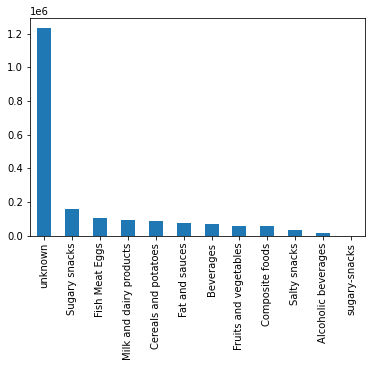

In [11]:
# df['pnns_groups_1'].dropna().value_counts()
df['pnns_groups_1'].value_counts().plot(kind='bar')
# df.groupby('brands').size().plot(kind='bar')

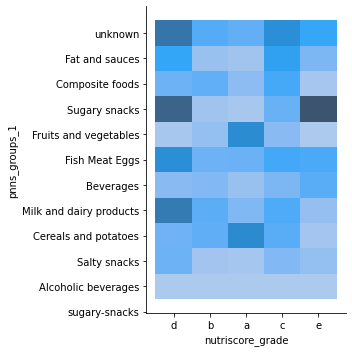

In [12]:
sns.displot(df, y='pnns_groups_1', x='nutriscore_grade')

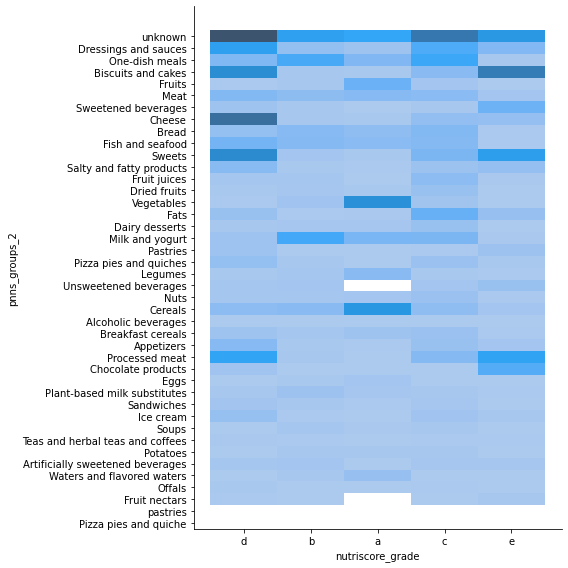

In [13]:
sns.displot(df, y='pnns_groups_2', x='nutriscore_grade', height=8)

In [ ]:
y = np.array([1, 2])
y_pred = np.array([5, 2])
print('MAE: ', mean_absolute_error(y, y_pred))
print('MSE: ', mean_squared_error(y, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y, y_pred)))

R^2: 0.999

Adj R^2: 0.99

RMSE: 0.003

MSE: 0.000

MAE: 0.003

MAPE: 0.001

Correlation between actual and predicted: 1.000


### Erreur quadratique moyenne - Mean Squared Error
$MSE = \frac{1}{m} \sum (y_{vrai}-y_{pred})^{2}$

### Erreur absolue moyenne - Mean Absolute Error

$MAE = \frac{1}{m} \sum |y_{vrai}-y_{pred}| $

### Root Mean Square Error

permet de "remettre à l'echelle" notre erreur MSE

RMSE = $ \sqrt{MSE} $ = $ \sqrt{\frac{1}{m} \sum (y_{vrai}-y_{pred})^{2}} $

utilisations :

MSE quand on veut prendre une importance exponentielle de l'erreur de prediction. la MSE pénalise beaucoup plus les grande erreurs.

MAE quand on contraire, qq rares grosses erreurs ne doivent pas être trop impactante dans l'appréciation du modele. quand le dataset comprends qq valeurs aberrantes (outliers)


### Median Absolute Error

Quand on veut s'affranchir des outliers, et une sensibilité linéaire aux erreurs

distribution of values


KeyboardInterrupt: 

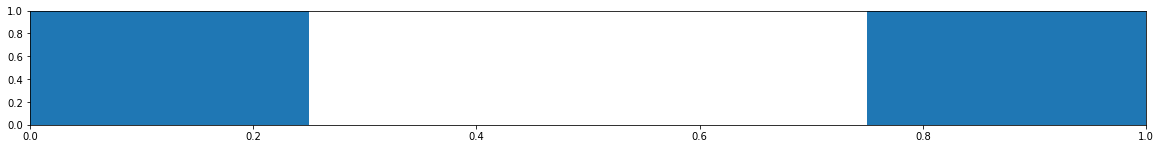

In [79]:
# df['nutriscore_grade'].value_counts().plot(kind='bar')

# this command preserve natural order of category
# df.groupby(['nutriscore_grade' ]).size().plot(kind='bar')

# .value_counts()
# .plot(kind='hist', bins=200, title='creator')    
    

size = qualis.size
plt.figure(figsize=(20,size*2.5))
print('distribution of values')
for i, col in enumerate(qualis):
    # sns.displot(df, x=col, bins=200)
    plt.subplot(size, 1, i+1)
    # df[col].value_counts().plot(kind='hist', bins=200, title=f'{col}')
    df.groupby(col).size().plot(kind='bar')
plt.show

### Categorization

Let's analyse `countries` category, its unique values :

In [16]:
countries_modalities = df['countries'].value_counts().index
tab = pd.DataFrame(countries_modalities, columns = ['countries'])
tab

,countries
0,France
1,United States
2,en:fr
3,en:es
4,en:it
...,...
10761,"Bulgaria,Croația,Cehia,Polonia,România,Slovacia"
10762,"Moldawien,Deutschland"
10763,"Alemania,Rumania,España"
10764,"Suisse,France,Belgique"


In [17]:
df['countries'].sample(20)

488641          United States
343391              en:france
598217                  en:fr
1079612                France
826603                 France
609538                  en:fr
1443866             en:france
110095          United States
896426                  en:fr
1259936    France, en:germany
1457050                France
1671208                 en:it
1265087           Deutschland
1761435             en:france
1524486                 en:ch
42105           United States
578440                 France
1406569                 en:be
654047                  en:es
861818              en:France
Name: countries, dtype: object

`countries` feature contains lots of different values, despite we can transform and categorize them, using standardized country code 'XX'

In [18]:
# add new column to dataset with standardized country code
df['countries_cleaned'] = df['countries'].fillna("XX").apply(cleanCategory)
print(f"our dataset results with {df['countries_cleaned'].unique().size} different country codes")

our dataset results with 421 different country codes


In [32]:
# Some values represent several countries and seperate them with ','
# This algorithm cannot process them, what is the impact ?
df[['countries', 'countries_cleaned']][df['countries'].fillna('').str.contains(',')].sample(25)

,countries,countries_cleaned
1221384,"Schweiz,Österreich",SC
1584023,"Frankreich, en:ch",CH
728298,"France,Hungary,Latvia",FR
1954543,"Ireland, Germany",IR
546898,"Spain,France",SP
1957146,"Austria, France",AU
1777432,"Francia,España",FR
1543902,"Belgium,France",BE
623964,"Ireland, Germany",IR
1936221,"Canada, France",CA


In [33]:
print(f"{df[['countries']][df['countries'].fillna('').str.contains(',')].count().values} rows have a country label possibly not standardized correctly")

[103613] rows have a country label possibly not standardized correctly


~100K lines contains countries code we are not able to process correclty, which represents about 5% of the dataset, which is insignificant.

Note : theses lines are not well explained, so we are not able to understand correctly what it means when several countries seperated by a comma appears in this columns

Now, let's transform `countries_cleaned` feature with numerical data so we can make statistics on it

In [37]:
df['countries_cleaned_cat'] = df['countries_cleaned'].astype('category')

In [22]:
# Example of application
pd.crosstab(df['countries_cleaned'], df['nutriscore_grade'])

col_0,a,b,c,d,e
row_0,,,,,
::,0,1,0,0,0
AD,10,20,18,24,8
AE,16,19,13,16,17
AF,16,22,35,41,24
AH,0,0,1,1,1
...,...,...,...,...,...
美国,0,0,1,0,0
西班,0,0,0,1,0
香港,0,4,1,4,0


In [43]:
df['countries_cleaned'].cat.codes.unique().max()
# df[df['countries_cleaned'] == 'FR']

420

What are the most represented countries ?

In [44]:
df['countries_cleaned'].mode()

0    FR
Name: countries_cleaned, dtype: object

In [45]:
most_countries = df.value_counts(subset='countries_cleaned').head(3).index
df.loc[~df['countries_cleaned'].isin(most_countries)].shape

(572967, 39)

<AxesSubplot:title={'center':'distribution of countries in dataset (top 20)'}>

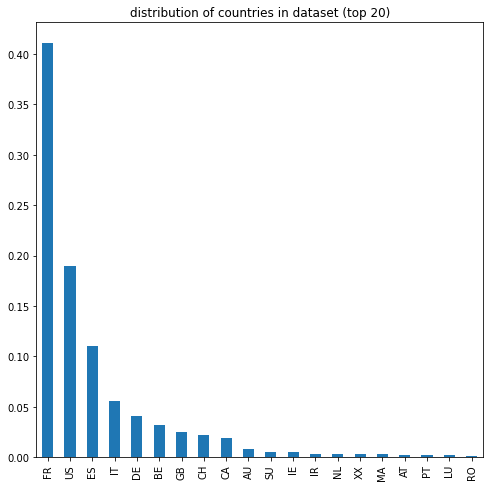

In [46]:
df['countries_cleaned'].value_counts(normalize=True).head(20).plot(kind='bar', figsize=(8,8), title='distribution of countries in dataset (top 20)')

The diagram above shows our dataset is composed of product coming in majority from France, US, Spain and Italy. The other countries represents less than 5% each.

In [74]:
print(df[df.countries_cleaned == 'FR'][df.nutriscore_score != 0].shape)
subset = df[df.countries_cleaned == 'FR'][df.nutriscore_score != 0].dropna(subset=['nutriscore_score'])
subset.sample(20).T
print(subset.shape)
# subset["nutriscore_score"].hist()

(802836, 39)
(277330, 39)


--------------------
FR
(277330, 39)
moy:
 9.925103667111383
med:
 11.0
mod:
 0    14.0
Name: nutriscore_score, dtype: float64
var:
 75.57891799758258
ect:
 8.693613632867669


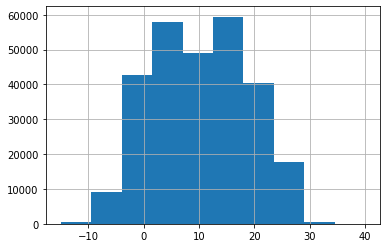

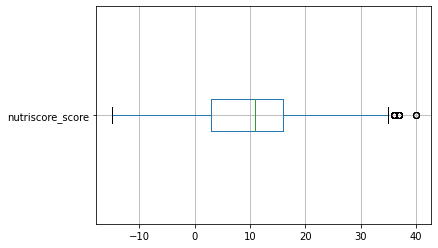

--------------------
US
(226175, 39)
moy:
 9.497990494086437
med:
 11.0
mod:
 0    14.0
Name: nutriscore_score, dtype: float64
var:
 82.31924322617247
ect:
 9.072995273126317


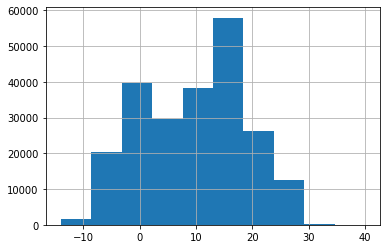

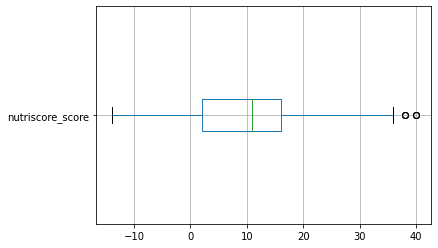

--------------------
ES
(52621, 39)
moy:
 9.175785332851904
med:
 9.0
mod:
 0    6.0
Name: nutriscore_score, dtype: float64
var:
 70.34818771348168
ect:
 8.387382649759202


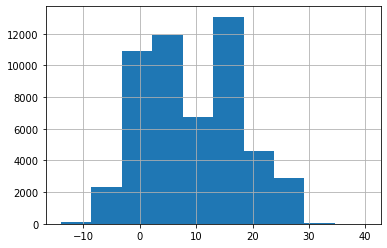

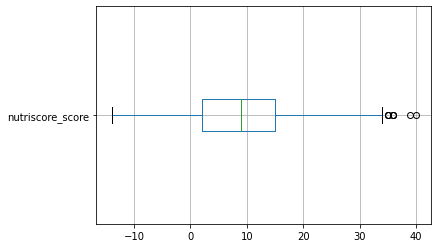

--------------------
IT
(16990, 39)
moy:
 9.380929958799294
med:
 11.0
mod:
 0    13.0
Name: nutriscore_score, dtype: float64
var:
 71.59050154836086
ect:
 8.461117039041646


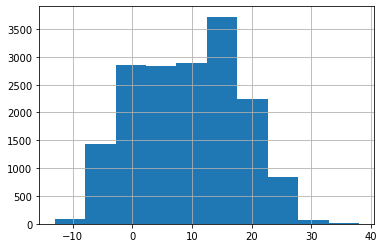

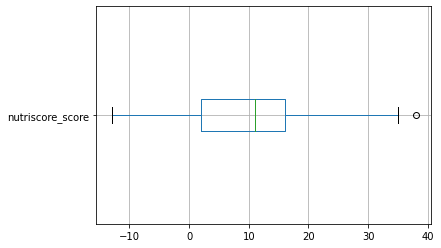

In [78]:
for cat in ['FR', 'US', 'ES', 'IT']:
    subset = df[df.countries_cleaned == cat][df.nutriscore_score != 0].dropna(subset=['nutriscore_score'])
    print("-"*20)
    print(cat)
    print(subset.shape)
    print("moy:\n",subset['nutriscore_score'].mean())
    print("med:\n",subset['nutriscore_score'].median())
    print("mod:\n",subset['nutriscore_score'].mode())
    print("var:\n",subset['nutriscore_score'].var(ddof=0))
    print("ect:\n",subset['nutriscore_score'].std(ddof=0))
    subset["nutriscore_score"].hist()
    plt.show()
    subset.boxplot(column="nutriscore_score", vert=False)
    plt.show()

TODO : mesurer le taux de score grade entre FR et US --> est-ce qu'on mange mieux en France ?

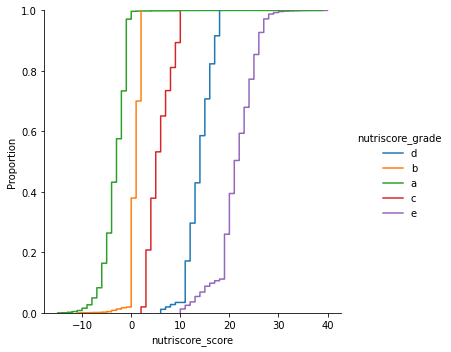

In [79]:
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')

Replace `nutriscore_grade` by a numerical feature, and analyse it

In [80]:
df['nutriscore_grade_cat'] = df['nutriscore_grade'].astype('category')

In [81]:
df['nutriscore_grade_cat'].dropna().cat.categories

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [82]:
df['nutriscore_grade_cat_codes'] = df['nutriscore_grade_cat'].dropna().cat.codes

In [83]:
df['nutriscore_grade_cat'].dropna().cat.codes.unique()

array([3, 1, 0, 2, 4], dtype=int8)

Pearson Correlation coefficient

In [86]:
# TODO : dessiner le graphe de correlation, en reduisant les valeurs car sinon trop grand fail
# plt.plot(df.nutriscore_grade_cat_codes, df.nutriscore_score)

In [84]:
df[['nutriscore_grade_cat_codes', 'nutriscore_score']].corr()

,nutriscore_grade_cat_codes,nutriscore_score
nutriscore_grade_cat_codes,1.000000,0.944571
nutriscore_score,0.944571,1.000000


In [ ]:
sns.displot(data=df, hue='nutriscore_grade', x='nutriscore_score', kind='ecdf')

In [ ]:
df['nutriscore_grade_cat'] = df['nutriscore_grade'].astype('category')

In [ ]:
df['nutriscore_grade_cat'].dropna().cat.categories

In [ ]:
df['nutriscore_grade_cat'].dropna().cat.codes.unique()

In [ ]:
# show product names for country FR
df['product_name'].unique().size

In [ ]:
pd.DataFrame({'columns': df.columns, 'multimode': getMultiModes(df, df.columns)})

## Analysis

In [ ]:
pd.crosstab(df['countries'], df['nutriscore_grade'])

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_1'] )

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_2'] )

In [ ]:
plt.figure(figsize=(20,20))
# sns.displot(df, x='nutriscore_grade')
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')
plt.savefig("nutriscore_grade_multivariate_analysis.png", format='png', dpi=150)
sns.displot(df, x='nutriscore_score', y='ecoscore_score_fr', hue='nutriscore_grade')
# sns.displot(df, x='nutriscore_score', y= 'nova_group', hue='nutriscore_grade', kind='kde')
# sns.displot(df, x='nutriscore_score', col='nutriscore_grade')
plt.savefig("nutriscore_ecoscore_multivariate_analysis.png", format='png', dpi=150)

In [ ]:
df['nutriscore_grade'].value_counts(normalize=True).plot.pie()

In [ ]:
df['nutriscore_score'].dropna().value_counts().sort_values(ascending=False)


We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis



In [ ]:
# most filled features
df.columns[[0, 1, 11, 12, 13, 25, 26, 27, 28, 29]]

In [ ]:
df.columns.get_loc('nutriscore_grade')